Extracting DATASETS/MNIST_TF/train-images-idx3-ubyte.gz
Extracting DATASETS/MNIST_TF/train-labels-idx1-ubyte.gz
Extracting DATASETS/MNIST_TF/t10k-images-idx3-ubyte.gz
Extracting DATASETS/MNIST_TF/t10k-labels-idx1-ubyte.gz


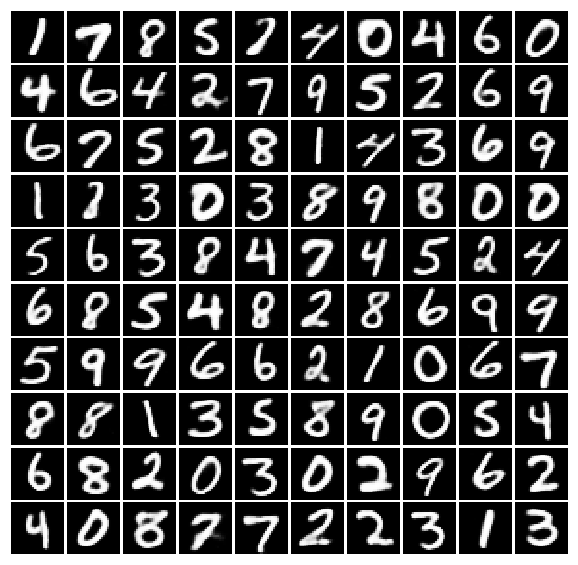

# samples 18000
Input's dimension 784
Label's dimension 10


In [1]:
#
# COMMENTS TO DO
#

%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import os
import time

from tensorflow.examples.tutorials.mnist import input_data

def plot(samples, w, h, fw, fh, iw=28, ih=28):
    fig = plt.figure(figsize=(fw, fh))
    gs = gridspec.GridSpec(w, h)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(iw, ih), cmap='Greys_r')

    return fig

mnist = input_data.read_data_sets("DATASETS/MNIST_TF/", one_hot=True)

X = np.load("DATASETS/MNIST_ALT/X_GEN_18K_CVAE")
Y = np.load("DATASETS/MNIST_ALT/Y_GEN_18K_CVAE")

fig=plot(X[:100], 10, 10, 10, 10)
plt.show()

X_TOTAL = X.shape[0]
X_DIM = X.shape[1]
Y_DIM = Y.shape[1]
print("# samples {}".format(X_TOTAL))
print("Input's dimension {}".format(X_DIM))
print("Label's dimension {}".format(Y_DIM))

#Determining data's input (Setting to None first dimension allows us to use a variable batch size)
images_placeholder = tf.placeholder(tf.float32, shape=(None, X_DIM))
labels_placeholder = tf.placeholder(tf.int32, shape=(None, Y_DIM))
learning_rate_placeholder = tf.placeholder(tf.float32)
is_training_placeholder = tf.placeholder(tf.bool)

#Defining a model
def model_dropout(images, is_training=True):
    
    h1 = tf.layers.dense(inputs=images, units=1024, activation=tf.nn.relu)
    h1_dropout = tf.layers.dropout(inputs=h1, rate=0.5, training=is_training)

    logits = tf.layers.dense(inputs=h1_dropout, units=10, activation=None)

    return logits


output_logits=model_dropout(images_placeholder, is_training_placeholder)

cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=labels_placeholder, logits=output_logits))

train_step = tf.train.GradientDescentOptimizer(learning_rate_placeholder).minimize(cross_entropy)

#Obtaining accuracy
y_pred = tf.argmax(input=output_logits, axis=1)
y_true = tf.argmax(input=labels_placeholder, axis=1)

correct_prediction = tf.equal(y_pred, y_true)

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [2]:
# Parameters
LEARNING_RATE = 0.01
BATCH_SIZE = 100
EPOCHS = 2000
TOTAL_BATCHES = int(X_TOTAL/BATCH_SIZE)
print("Total batches with batch size {}: {}".format(BATCH_SIZE, TOTAL_BATCHES))

X_TOTAL_VALID = mnist.validation.images.shape[0]
BATCH_SIZE_VAL = 100
TOTAL_BATCHES_VALIDATION = int(X_TOTAL_VALID/BATCH_SIZE_VAL)

# Initializing the variables
init = tf.global_variables_initializer()

#Models' managing
MODELS_PATH = "MODELS_MLP/"

if not os.path.exists(MODELS_PATH):
    os.makedirs(MODELS_PATH)

MODEL_NAME = "MLP_GEN_x20.ckpt"


# 'Saver' op to save and restore all the variables
MLP_SAVER = tf.train.Saver()

#A Session with a "with" block. The Session closes automatically at the end of the with block.
with tf.Session() as sess:
    
    sess.run(init)
    
    training_acc = []
    training_acc_per_batch = []
    validation_acc = []
    
    for epoch in range(EPOCHS):
        
        batch_indexes = np.random.permutation(TOTAL_BATCHES)
        
        training_total_acc = 0
        start_time = time.time()
        
        perm = np.random.permutation(X_TOTAL)
        X = X[perm]
        Y = Y[perm]
        
        for minibatch_number, batch_index in enumerate(batch_indexes):
            
            X_minibatch = X[batch_index*BATCH_SIZE:(batch_index+1)*BATCH_SIZE]
            Y_minibatch = Y[batch_index*BATCH_SIZE:(batch_index+1)*BATCH_SIZE]

            _, minibatch_acc = sess.run([train_step, accuracy], 
                              feed_dict={
                                  images_placeholder: X_minibatch,
                                  labels_placeholder: Y_minibatch,
                                  learning_rate_placeholder: LEARNING_RATE,
                                  is_training_placeholder: True
                              })
            
            training_acc_per_batch.append(minibatch_acc)

            training_total_acc+=minibatch_acc
            
        training_total_acc/=TOTAL_BATCHES
        
        training_acc.append(training_total_acc)
        
        start_time_val = time.time()
        
        val_acc = sess.run(accuracy, 
                              feed_dict={
                                  images_placeholder: mnist.validation.images,
                                  labels_placeholder: mnist.validation.labels,
                                  is_training_placeholder: False
                              })

        validation_acc.append(val_acc)
        
        if epoch % 100 == 0:
            print("E {} | TRAINING ACC: {:.4f} | TIME {:.2f} secs".format(epoch, training_total_acc, time.time() - start_time))
            print("E {} | VALIDATION ACC: {:.4f} | TIME {:.2f} secs".format(epoch, val_acc, time.time() - start_time_val))


    print("Optimization Finished!")
    #Saving the model
    
    # Save model weights to disk
    save_path = MLP_SAVER.save(sess, MODELS_PATH + MODEL_NAME)
    print("Model saved in file: {}".format(save_path))

Total batches with batch size 100: 180
E 0 | TRAINING ACC: 0.7817 | TIME 0.41 secs
E 0 | VALIDATION ACC: 0.7200 | TIME 0.01 secs
E 100 | TRAINING ACC: 0.9994 | TIME 0.31 secs
E 100 | VALIDATION ACC: 0.7664 | TIME 0.01 secs
E 200 | TRAINING ACC: 0.9997 | TIME 0.29 secs
E 200 | VALIDATION ACC: 0.7662 | TIME 0.01 secs
E 300 | TRAINING ACC: 0.9998 | TIME 0.29 secs
E 300 | VALIDATION ACC: 0.7654 | TIME 0.01 secs
E 400 | TRAINING ACC: 0.9998 | TIME 0.28 secs
E 400 | VALIDATION ACC: 0.7650 | TIME 0.01 secs
E 500 | TRAINING ACC: 0.9999 | TIME 0.28 secs
E 500 | VALIDATION ACC: 0.7646 | TIME 0.01 secs
E 600 | TRAINING ACC: 1.0000 | TIME 0.29 secs
E 600 | VALIDATION ACC: 0.7634 | TIME 0.01 secs
E 700 | TRAINING ACC: 1.0000 | TIME 0.31 secs
E 700 | VALIDATION ACC: 0.7640 | TIME 0.01 secs
E 800 | TRAINING ACC: 1.0000 | TIME 0.31 secs
E 800 | VALIDATION ACC: 0.7648 | TIME 0.01 secs
E 900 | TRAINING ACC: 1.0000 | TIME 0.29 secs
E 900 | VALIDATION ACC: 0.7640 | TIME 0.01 secs
E 1000 | TRAINING ACC: 1.

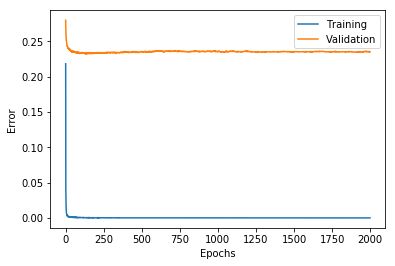

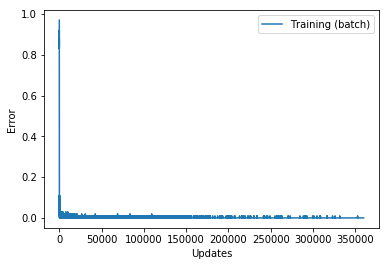

In [3]:
max_epochs = 10000

plt.plot([1.0 - x for x in training_acc[:max_epochs]], label="Training")
plt.xlabel("Epochs")
plt.plot([1.0 - x for x in validation_acc[:max_epochs]], label="Validation")
plt.ylabel("Error")
plt.legend()
plt.show()

plt.xlabel("Updates")
plt.plot([1.0 - x for x in training_acc_per_batch], label="Training (batch)")
plt.ylabel("Error")
plt.legend()
plt.show()

f = open("PLOT_DATA/training_mlp_acc_gen_x20", "wb")
np.save(f, training_acc)
f.close()

f = open("PLOT_DATA/validation_acc_gen_x20", "wb")
np.save(f, validation_acc)
f.close()

f = open("PLOT_DATA/training_acc_per_batch_gen_x20", "wb")
np.save(f, training_acc_per_batch)
f.close()

In [4]:
with tf.Session() as sess:
    
    sess.run(init)
    
    MLP_SAVER.restore(sess, save_path)
    print("Model restored in file: {}".format(save_path))

    start_time = time.time()

    test_acc = sess.run(accuracy, 
                      feed_dict={
                          images_placeholder: mnist.test.images,
                          labels_placeholder: mnist.test.labels,
                          is_training_placeholder: False
                      })
    
    print("TEST ACC: {:.4f} | TIME {:.2f} secs".format(test_acc, time.time() - start_time))


Model restored in file: MODELS_MLP/MLP_GEN_x20.ckpt
TEST ACC: 0.7734 | TIME 0.02 secs
